In [1]:
%matplotlib inline
#import deepdish as dd
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
import brainiak.eventseg.event
from scipy import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve
from sklearn import decomposition
import seaborn as sns 

from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp

Using Numpy backend.


In [2]:
nostop = True
if nostop == True:
    embeddings=np.load("Exp1-NYT4-IGBA-embeddings.npy")
else:
    embeddings=np.load("Exp1-NYT4-IGBA-embeddings-stop.npy")
print(embeddings.shape)

embeddingsn = np.empty((embeddings.shape[0],embeddings.shape[1]))

(789, 100)


In [3]:
in_small = np.load('CH2020_50/in_small.npy')
out_small = np.load('CH2020_50/out_small.npy')

In [4]:
inputDataTesting=embeddings

averages1 = np.empty((len(inputDataTesting),embeddings.shape[1]))
averages2 = np.empty((len(inputDataTesting),embeddings.shape[1]))
averages3 = np.empty((len(inputDataTesting),embeddings.shape[1]))

# data structures for normalizing

averages1n = np.empty((len(inputDataTesting),embeddings.shape[1]))
averages2n = np.empty((len(inputDataTesting),embeddings.shape[1]))
averages3n = np.empty((len(inputDataTesting),embeddings.shape[1]))

print(averages1.shape)

#update to simpler integrator formula


for num in range(len(inputDataTesting)):
        if num == 0:
            averages1[num] = inputDataTesting[num]
            averages2[num] = inputDataTesting[num]
            averages3[num] = inputDataTesting[num]
        else:
            #averages1[num] = .75*averages1[num-1] + 1.25*inputDataTesting[num]
            #averages2[num] = .85*averages2[num-1] + 1.15*inputDataTesting[num]
            #averages3[num] = .95 *averages3[num-1] + 1.05*inputDataTesting[num]
            averages1[num] = .8*averages1[num-1] + 1.2*inputDataTesting[num]
            averages2[num] = .9*averages2[num-1] + 1.1*inputDataTesting[num]
            averages3[num] = .95 *averages3[num-1] + 1.05*inputDataTesting[num]


(789, 100)


In [5]:
# set the seed
res_seed = 30 #194
numNode = 1000
vectorDim = 100


# set up the reservoirs
# 
np.random.seed(res_seed)
esn1 = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)
np.random.seed(res_seed)
esn2 = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.1, regressionParameters=[1e-2], solver="lsqr", feedback=False)
np.random.seed(res_seed)
esn3 = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

# train the reervoir with a new seed
esn1.fit(in_small, out_small, transientTime="Auto", verbose=1)
esn2.fit(in_small, out_small, transientTime="Auto", verbose=1)
esn3.fit(in_small, out_small, transientTime="Auto", verbose=1)
    

#run the reservoir
states1 = np.empty((0,numNode))
states2 = np.empty((0,numNode))
states3 = np.empty((0,numNode))

states1n = np.empty((0,numNode))
states2n = np.empty((0,numNode))
states3n = np.empty((0,numNode))

prediction1,states1  = esn1.predict(inputDataTesting)
prediction2,states2  = esn2.predict(inputDataTesting)
prediction3,states3  = esn3.predict(inputDataTesting)

states1 = states1.T
states2 = states2.T
states3 = states3.T

states1 = states1[:,101:]
states2 = states2[:,101:]
states3 = states3[:,101:]

states1n = np.empty((states1.shape[0],states1.shape[1]))
states2n = np.empty((states2.shape[0],states2.shape[1]))
states3n = np.empty((states3.shape[0],states3.shape[1]))

    


100% (9907 of 9907) |####################| Elapsed Time: 0:00:08 Time:  0:00:08
100% (9812 of 9812) |####################| Elapsed Time: 0:00:07 Time:  0:00:07
100% (9627 of 9627) |####################| Elapsed Time: 0:00:07 Time:  0:00:07


In [6]:
seg_no = 10
# 2 set up the segmentation HMM
evE = brainiak.eventseg.event.EventSegment(seg_no)
evE.fit(embeddings)



EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

In [7]:

evA1 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
evA1.fit(averages1)

evA2 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
evA2.fit(averages2)

evA3 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
evA3.fit(averages3)

EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

In [8]:

evS1 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
evS1.fit(states1)

evS2 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
evS2.fit(states2)

evS3 = brainiak.eventseg.event.EventSegment(n_events=seg_no)
evS3.fit(states3)


EventSegment(event_chains=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
             n_events=10)

In [9]:
for j in range(embeddings.shape[1]):
    mean = embeddings[:,j].mean()
    if abs(mean) > 0.01:
        embeddingsn[:,j] = embeddings[:,j]/mean
    else:
        embeddingsn[:,j] = embeddings[:,j]
        

In [10]:
factor = 0.005
factor2=0.1

for j in range(embeddings.shape[1]):
    mean = embeddings[:,j].mean()
    if abs(mean) > 0.01:
        embeddingsn[:,j] = embeddings[:,j]/mean
    else:
        embeddingsn[:,j] = embeddings[:,j]

for j in range(averages1.shape[1]):
    mean = averages1[:,j].mean()
    if abs(mean) > factor2:  #was .0001
        averages1n[:,j] = averages1[:,j]/mean  
    else:
        averages1n[:,j] = averages1[:,j]
        
for j in range(averages2.shape[1]):
    mean = averages2[:,j].mean()
    if abs(mean) > factor2:  #was .0001
        averages2n[:,j] = averages2[:,j]/mean 
    else:
        averages2n[:,j] = averages2[:,j]
        
for j in range(averages3.shape[1]):
    mean = averages3[:,j].mean()
    if abs(mean) > factor2:  #was .0001
        averages3n[:,j] = averages3[:,j]/mean  
    else:
        averages3n[:,j] = averages3[:,j]
        
for j in range(states1.shape[1]):
    mean = states1[:,j].mean()
    if abs(mean) > factor: #0.001:
        states1n[:,j] = states1[:,j]/mean
    else:
        states1n[:,j] = states1[:,j]
        
for j in range(states2.shape[1]):
    mean = states2[:,j].mean()
    if abs(mean) > factor:
        states2n[:,j] = states2[:,j]/mean
    else:
        states2n[:,j] = states2[:,j]/mean

for j in range(states3.shape[1]):
    mean = states3[:,j].mean()
    if abs(mean) > factor:
        states3n[:,j] = states3[:,j]/mean
    else:
        states3n[:,j] = states3[:,j]


embedding bounds:  [ 73 136 277 342 421 491 565 598 699]
integrator1 bounds:  [ 78 139 280 345 424 486 570 600 702]
integrator3 bounds:  [ 89 195 287 351 428 502 576 613 712]
Reservoir bounds:  [ 78 142 280 346 425 487 569 599 703]
Reservoir2 bounds:  [ 89 195 283 349 426 494 572 604 708]
Reservoir3 bounds:  [ 87 144 199 289 427 497 575 613 713]


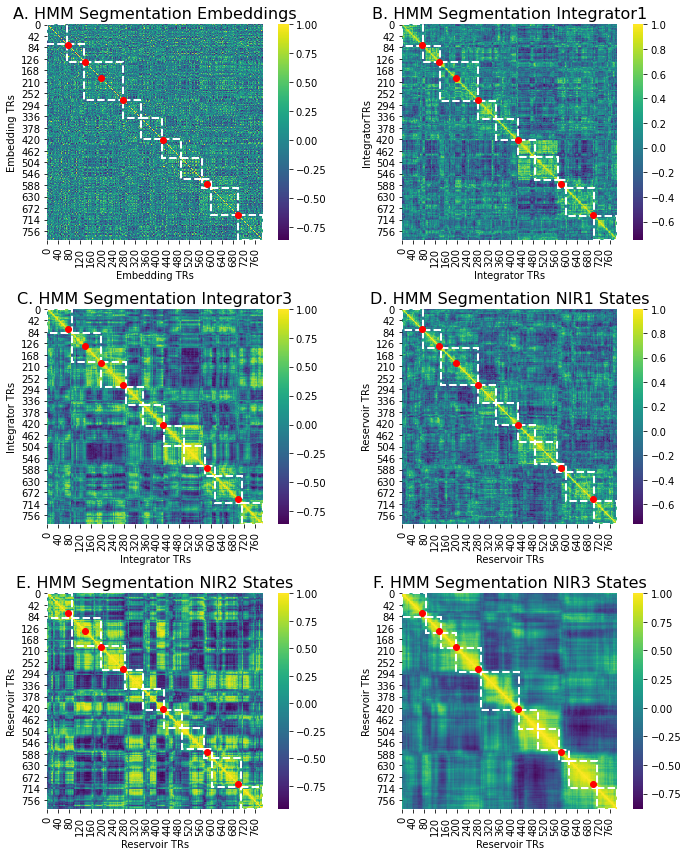

In [11]:
nTR=embeddings.shape[0]

fig=plt.figure(figsize=(10,12))

# embeddings
plt.subplot(3,2,1)

edge='white'

if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro')    

sns.heatmap(np.corrcoef(embeddingsn),cmap='viridis', square=True)


boundsE = np.where(np.diff(np.argmax(evE.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],boundsE,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
print('embedding bounds: ',boundsE)    
    
plt.title('A. HMM Segmentation Embeddings', fontsize = 16)
plt.xlabel('Embedding TRs')
plt.ylabel('Embedding TRs')

 



# averages 1

plt.subplot(3,2,2)

#ground  68 349 464 557

if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(averages1n),cmap='viridis', square=True)




boundsA1 = np.where(np.diff(np.argmax(evA1.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],boundsA1,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('B. HMM Segmentation Integrator1', fontsize=16)

plt.xlabel('Integrator TRs')
plt.ylabel('IntegratorTRs')
print('integrator1 bounds: ',boundsA1)


# averages 2

plt.subplot(3,2,3)



#ground  68 349 464 557

if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(averages2n),cmap='viridis', square=True)




boundsA3 = np.where(np.diff(np.argmax(evA3.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],boundsA3,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('C. HMM Segmentation Integrator3', fontsize=16)

plt.xlabel('Integrator TRs')
plt.ylabel('Integrator TRs')
print('integrator3 bounds: ',boundsA3)

# states

plt.subplot(3,2,4)

#ground  74 137 197  278 424 583 698
if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(states1n),cmap='viridis', square=True)




boundsS1 = np.where(np.diff(np.argmax(evS1.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],boundsS1,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('D. HMM Segmentation NIR1 States', fontsize=16)

plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')
print('Reservoir bounds: ',boundsS1)


# states2

plt.subplot(3,2,5)

#ground  74 137 197  278 424 583 698
if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(states2n),cmap='viridis', square=True)




boundsS2 = np.where(np.diff(np.argmax(evS2.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],boundsS2,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('E. HMM Segmentation NIR2 States', fontsize=16)

plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')
print('Reservoir2 bounds: ',boundsS2)

# states3

plt.subplot(3,2,6)

#ground  74 137 197  278 424 583 698
if nostop == True:
    plt.plot(74,74,'ro') 
    plt.plot(137,137,'ro') 
    plt.plot(197,197,'ro')
    plt.plot(278,278,'ro') 
    plt.plot(424,424,'ro') 
    plt.plot(583,583,'ro')
    plt.plot(698,698,'ro')
else:
    plt.plot(131,131,'ro') 
    plt.plot(233,233,'ro') 
    plt.plot(337,337,'ro')
    plt.plot(470,470,'ro') 
    plt.plot(706,706,'ro') 
    plt.plot(939,939,'ro')
    plt.plot(1126,1126,'ro') 


#plt.imshow(np.corrcoef(igba),vmin=scale1, cmap=color)
#plt.imshow(np.corrcoef(igba))

sns.heatmap(np.corrcoef(states3n),cmap='viridis', square=True)




boundsS3 = np.where(np.diff(np.argmax(evS3.segments_[0], axis=1)))[0]
ax = plt.gca()
bounds_aug = np.concatenate(([0],boundsS3,[nTR]))
for i in range(len(bounds_aug)-1):
    rect = patches.Rectangle((bounds_aug[i],bounds_aug[i]),bounds_aug[i+1]-bounds_aug[i],bounds_aug[i+1]-bounds_aug[i],linewidth=2,linestyle='--', edgecolor=edge,facecolor='none')
    ax.add_patch(rect)
    
plt.title('F. HMM Segmentation NIR3 States', fontsize=16)

plt.xlabel('Reservoir TRs')
plt.ylabel('Reservoir TRs')
print('Reservoir3 bounds: ',boundsS3)



fig.tight_layout()

if nostop == True:
    plt.savefig('HMM_NYT4-IGBA-revisionV.png',dpi=300)
else:
    plt.savefig('HMM_NYT4-IGBA-revision-nostopV.png', dpi=300)


In [12]:
if nostop == True:
    g = [74, 137, 197,  278, 424, 583, 698]
else:
    g = [131, 233, 337, 470, 706, 939, 1126]
ground = np.array(g)

    

In [13]:
boundsA2 = np.where(np.diff(np.argmax(evA2.segments_[0], axis=1)))[0]

p = 0.49248701045974397


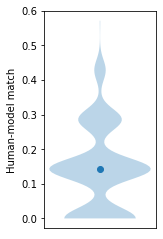

In [14]:
bounds = boundsA3
human_bounds = ground
np.random.seed(0)

event_counts = np.diff(np.concatenate(([0],bounds,[nTR])))
nPerm = 1000
perm_bounds = bounds
threshold = 3

match = np.zeros(nPerm+1)
for p in range(nPerm+1):
    for hb in human_bounds:
        # check if match 
        if np.any(np.abs(perm_bounds - hb) <= threshold):
            match[p] += 1
    match[p] /= len(human_bounds)
    perm_counts = np.random.permutation(event_counts)
    perm_bounds = np.cumsum(perm_counts)[:-1]

plt.figure(figsize=(2,4))
plt.violinplot(match[1:], showextrema=False)
plt.scatter(1, match[0])
plt.gca().xaxis.set_visible(False)
plt.ylabel('Human-model match')
print('p = ' + str(norm.sf((match[0]-match[1:].mean())/match[1:].std())))

In [15]:
print('Embeddings:  ', boundsE)
print('Integrator1: ',boundsA1)
print('Integrator2: ',boundsA2)
print('Integrator3: ',boundsA3)
print('Ground:      ',ground)

Embeddings:   [ 73 136 277 342 421 491 565 598 699]
Integrator1:  [ 78 139 280 345 424 486 570 600 702]
Integrator2:  [ 84 146 283 347 426 494 572 604 707]
Integrator3:  [ 89 195 287 351 428 502 576 613 712]
Ground:       [ 74 137 197 278 424 583 698]


In [16]:
# works for .2 - .05